In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from torch import nn
from torch.nn import functional as F
import csv
import itertools
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import matplotlib
from torchvision import transforms
from contextlib import nullcontext
from tqdm import tqdm
from itertools import product
import torchvision.models as models
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from IPython.display import Image, display


matplotlib.use('Agg') 

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


**Helper Functions**

In [4]:
def display_images(image_paths, cla):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, path in enumerate(image_paths):     # Iterate over the image paths and display each image
        image = mpimg.imread(path)
        parts = path.split("/")

        family = parts[2]  # 'family'
        animal = parts[4]
        animal = animal[:-4]
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].text(0.5, -0.15, f"{family} – {animal}", size=9, ha='center', va='top',transform=axes[i].transAxes)
    fig.suptitle(f"Similarity: {cla}", fontsize=16)     # Set a title indicating the label
    plt.savefig(f"data_preprocessing/Class_{cla}.png")


In [3]:
def make_dataloaders(train_dataset, val_dataset, batch_size, num_workers=2, pin_memory=True, sampler=None):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    return train_loader, val_loader

In [5]:
def save_grid_search_results_to_csv(results, csv_path):
    """
    results: list of dicts with params + metrics
    """
    if not results:
        print("No results to save.")
        return
    fieldnames = list(results[0].keys())
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for row in results:
            writer.writerow(row)
    print(f"Saved grid search results to {csv_path}")

**Dataset**

**Network Model**

In [4]:
class MyDataset(Dataset):
    def __init__(self, df, transform=None, roots=None):
        self.df = df
        self.roots = roots or [
            "/kaggle/input/images-data",
            "/kaggle/input/validation-set",
            "/kaggle/input/test-set",
        ]
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
        ])


    def __len__(self):
        return len(self.df)

    def _resolve_path(self, rel_path: str):
        for r in self.roots:
            p = os.path.join(r, rel_path)
            if os.path.exists(p):
                return p
        raise FileNotFoundError(f"Could not find {rel_path} in any of: {self.roots}")

    def _load_img(self, path: str):
        return Image.open(path)
        
    def __getitem__(self, idx):# Retrieve paths to the images and their label from the DataFrame
        # Open and apply transformations to the images
        img1_path = self.df.iloc[idx]['image1']
        img2_path = self.df.iloc[idx]['image2']

        p1 = self._resolve_path(img1_path)
        p2 = self._resolve_path(img2_path)
        img1 = self._load_img(p1)
        img2 = self._load_img(p2)
            
        img1 = self.transform(img1)
        img2 = self.transform(img2)

        label = torch.tensor(self.df.iloc[idx]['similarity_class'])
        label = label.clone().detach().to(torch.float32)
        return img1, img2, label


In [5]:
import clip 

class SiameseClassificationCLIP(nn.Module):
    """
    Siamese classifier using CLIP image encoder as the backbone.

    - Backbone: CLIP model
    - Pairwise head takes [z1, z2, |z1-z2|, z1*z2] -> logits (num_classes).
      For multi-class use CrossEntropyLoss (targets 0-4).
    """
    def __init__(
        self,
        clip_name="ViT-B/32",
        device=None,
        freeze_backbone=True,
        pair_hidden1=1024,
        pair_hidden2=512,
        dropout=0.2,
        use_batchnorm=True,
        num_classes=5,
        normalize_embeds=True,
        jit=False,
    ):
        super().__init__()

        # Select device automatically if not provided
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)

        # Load CLIP model + its preprocessing pipeline
        self.clip_model, self.preprocess = clip.load(clip_name, device=self.device, jit=jit)
        self.clip_model.eval()  # encoder is usually used in eval mode

        # Optionally freeze CLIP
        if freeze_backbone:
            for p in self.clip_model.parameters():
                p.requires_grad = False

        # Feature dimension (512 for ViT-B/32/RN50 etc.; accessed from model)
        if hasattr(self.clip_model.visual, "output_dim"):
            feat_dim = self.clip_model.visual.output_dim
        else:
            # Fallback (ViT-B/32, RN50 typically 512)
            feat_dim = 512

        self.normalize_embeds = normalize_embeds

        # Pairwise head
        pair_in = 4 * feat_dim
        layers = []
        # FC1
        layers.append(nn.Linear(pair_in, pair_hidden1))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(pair_hidden1))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Dropout(dropout))
        # FC2
        layers.append(nn.Linear(pair_hidden1, pair_hidden2))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(pair_hidden2))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Dropout(dropout))
        # FC3 -> logits
        layers.append(nn.Linear(pair_hidden2, num_classes))

        self.head = nn.Sequential(*layers)

    def encode(self, x):
        """
        x: preprocessed images (use self.preprocess on PIL images), shape [B, 3, H, W]
        Returns: float32 features [B, D]
        """
        # Ensure tensors live on the same device as the model
        x = x.to(self.device)

        # Match CLIP dtype (fp16 on CUDA, fp32 on CPU)
        if x.dtype != self.clip_model.dtype:
            x = x.to(dtype=self.clip_model.dtype)

        # If the backbone is frozen, you can safely skip grads
        with torch.no_grad() if not any(p.requires_grad for p in self.clip_model.parameters()) else torch.enable_grad():
            z = self.clip_model.encode_image(x)  # [B, D]

        if self.normalize_embeds:
            z = z / z.norm(dim=-1, keepdim=True).clamp_min(1e-6)

        # Head is in float32 for numeric stability
        return z.float()

    def forward(self, x1, x2):
        z1 = self.encode(x1)  # [B, D]
        z2 = self.encode(x2)  # [B, D]
        feat = torch.cat([z1, z2, torch.abs(z1 - z2), z1 * z2], dim=1)  # [B, 4D]
        logits = self.head(feat)  # [B, num_classes]
        return logits


In [6]:
@torch.no_grad()
def evaluate(model, dataloader, loss_fn, device="cuda", is_logits=True):
    model.eval()
    sum_loss, total = 0.0, 0
    all_probs, all_preds, all_targets = [], [], []

    for img1, img2, label in dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        outputs = model(img1, img2)

        loss = loss_fn(outputs, label.long())
        probs = F.softmax(outputs, dim=1)              # [B, K]
        preds = probs.argmax(dim=1)                   # [B]
        targets = label.long()

        sum_loss += loss.item()
        total += 1

        all_probs.append(probs.detach().cpu())
        all_preds.append(preds.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = sum_loss / max(1, total)

    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    f1 = f1_score(all_targets, all_preds)
    bal_acc = accuracy_score(all_targets, all_preds)
    recalls = recall_score(all_targets, all_preds, average=None)  # per class
    recall = recall_score(all_targets, all_preds)  

    return avg_loss, f1, bal_acc, recall, recalls 


In [7]:
def train_one_epoch(
    model,
    dataloader,
    optimizer,
    loss_fn,
    device="cuda",
    is_logits=True,              # True if model outputs raw logits
    scaler=None,                 # torch.cuda.amp.GradScaler() or None
    grad_clip=None,              # e.g., 1.0 or None
    scheduler=None,              # optional LR scheduler
    scheduler_step="epoch",      # "epoch" or "step"
    accumulation_steps=1,        # gradient accumulation
):
    """
    Trains `model` for one epoch on `dataloader`.

    """
    model.train()
    sum_loss, n_steps = 0.0, 0
    all_probs, all_preds, all_targets = [], [], []

    # New AMP API
    use_amp = (scaler is not None) and torch.cuda.is_available() and str(device).startswith("cuda")
    autocast_ctx = (lambda: torch.amp.autocast("cuda", enabled=use_amp)) if use_amp else (lambda: nullcontext())

    optimizer.zero_grad(set_to_none=True)
    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for step, (img1, img2, label) in enumerate(progress_bar):
        img1 = img1.to(device, non_blocking=True)
        img2 = img2.to(device, non_blocking=True)
        label  = label.to(device, non_blocking=True)

        with autocast_ctx():
            outputs = model(img1, img2)
            loss = loss_fn(outputs, label.long())
            loss_to_backprop = loss / accumulation_steps

        if use_amp:
            scaler.scale(loss_to_backprop).backward()
        else:
            loss_to_backprop.backward()

        # Gradient step (with accumulation)
        if (step + 1) % accumulation_steps == 0:
            if grad_clip is not None:
                if use_amp:
                    scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            if use_amp:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()

            optimizer.zero_grad(set_to_none=True)

            if scheduler is not None and scheduler_step == "step":
                scheduler.step()

        # logging stats
        sum_loss += loss.item()
        n_steps += 1
        with torch.no_grad():
            probs = F.softmax(outputs, dim=1).detach().cpu()
            preds = probs.argmax(dim=1)
            all_probs.append(probs)
            all_preds.append(preds)
            all_targets.append(label.cpu())

        avg_loss = sum_loss / max(1, n_steps)
        progress_bar.set_postfix({"loss": f"{avg_loss:.4f}"})

    if scheduler is not None and scheduler_step == "epoch":
        scheduler.step()

    # Concatenate all predictions
    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    avg_loss = sum_loss / max(1, n_steps)
    
    f1 = f1_score(all_targets, all_preds)
    bal_acc = accuracy_score(all_targets, all_preds)
    recalls = recall_score(all_targets, all_preds, average=None)  # per class
    recall = recall_score(all_targets, all_preds)  

    return avg_loss, f1, bal_acc, recall, recalls 


**Data Preprocessing**

In [8]:
train_df = pd.read_csv('/kaggle/input/pairs-csv/train_animal_similarity_pairs.csv')

val_df = pd.read_csv('/kaggle/input/pairs-csv/val_animal_similarity_pairs.csv')


In [ ]:

target_col = "similarity_class" 

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Train distribution
train_counts = train_df[target_col].value_counts().sort_index()
axes[0].bar(train_counts.index.astype(str), train_counts.values, color="skyblue", edgecolor="black")
axes[0].set_title("Train set similarity distribution")
axes[0].set_xlabel("Similarity class")
axes[0].set_ylabel("Count")

# Val distribution
val_counts = val_df[target_col].value_counts().sort_index()
axes[1].bar(val_counts.index.astype(str), val_counts.values, color="lightgreen", edgecolor="black")
axes[1].set_title("Validation set similarity distribution")
axes[1].set_xlabel("Similarity class")

plt.tight_layout()
plt.savefig("similarity_distribution.png", dpi=300)
plt.close()


In [ ]:
# Count per class
counts = train_df['similarity_class'].value_counts().sort_index()
print(counts)

# Target = count of class '4'
n_per_class = int(counts.get(4, 0))
print("Target per class:", n_per_class)

# Downsample each class 
balanced_train_df = (
    train_df.groupby('similarity_class', group_keys=False)
            .apply(lambda g: g.sample(n=min(len(g), n_per_class), random_state=42))
            .reset_index(drop=True)
)

print(balanced_train_df['similarity_class'].value_counts().sort_index())

In [ ]:
# Count per class
counts = val_df['similarity_class'].value_counts().sort_index()
print(counts)

# Target = count of class '4'
n_per_class = int(counts.get(4, 0))
print("Target per class:", n_per_class)

balanced_val_df = (
    val_df.groupby('similarity_class', group_keys=False)
            .apply(lambda g: g.sample(n=min(len(g), n_per_class), random_state=42))
            .reset_index(drop=True)
)

print(balanced_val_df['similarity_class'].value_counts().sort_index())

In [12]:
train_dataset = MyDataset(balanced_train_df)
val_dataset = MyDataset(balanced_val_df)

In [ ]:
# Examples with score 0
for idx, row in train_df[train_df['similarity_class'] == 0].head(1).iterrows():
    display_images([f"data_preprocessing/{row['image1']}", f"data_preprocessing/{row['image2']}"], row['similarity_class'])

for idx, row in train_df[train_df['similarity_class'] == 4].head(1).iterrows():
    display_images([f"data_preprocessing/{row['image1']}", f"data_preprocessing/{row['image2']}"], row['similarity_class'])

for idx, row in train_df[train_df['similarity_class'] == 3].head(1).iterrows():
    display_images([f"data_preprocessing/{row['image1']}", f"data_preprocessing/{row['image2']}"], row['similarity_class'])

for idx, row in train_df[train_df['similarity_class'] == 2].head(1).iterrows():
    display_images([f"data_preprocessing/{row['image1']}", f"data_preprocessing/{row['image2']}"], row['similarity_class'])

for idx, row in train_df[train_df['similarity_class'] == 1].head(1).iterrows():
    display_images([f"data_preprocessing/{row['image1']}", f"data_preprocessing/{row['image2']}"], row['similarity_class'])


**Experiments**

In [22]:
# choose a stable place on Kaggle
CSV_PATH = "/kaggle/working/results.csv"

FIELDNAMES = [
    "experiment_id", "timestamp",
    "clip_name", "freeze_backbone",
    "learning_rate", "weight_decay",
    "batch_size", "dropout", "hidden_size",
    "scheduler_type",
    "epochs", "best_epoch",
    "train_loss", "train_f1", "train_bal_acc", "train_recall",
    "val_loss", "val_f1", "val_bal_acc", "val_recall",
]

def save_result_row(row: dict, csv_path: str = CSV_PATH, fieldnames=FIELDNAMES):
    os.makedirs(os.path.dirname(csv_path) or ".", exist_ok=True)
    file_exists = os.path.exists(csv_path)

    # keep only known fields; fill missing with ""
    row_to_write = {k: row.get(k, "") for k in fieldnames}

    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerow(row_to_write)
        f.flush()
        os.fsync(f.fileno())

In [16]:
def run_grid_search_siamese(
    grid, grid_names,
    train_dataset, val_dataset,
    device="cuda",
    freeze_backbone=False,
    epochs=5,
    early_stopping_patience=None,
    num_workers=2,
    pin_memory=True,
    accumulation_steps=1,
    grad_clip=1.0,
    use_amp=True,
    scheduler_factory=None,
    save_best_model_dir=None,
    sampler=None                
):
    results = []
    total_combos = len(grid)

    # Safer default for pin_memory
    pin_memory = bool(pin_memory and (device == "cuda" and torch.cuda.is_available()))

    for i, combo in enumerate(grid):
        params = dict(zip(grid_names, combo))
        print(f"\n=== Combo {i+1}/{total_combos}: {params}")

        # Build CLIP-based model
        model = SiameseClassificationCLIP(
            clip_name=params["clip_name"],
            device=device,
            freeze_backbone=freeze_backbone,
            pair_hidden1=max(2 * params["hidden_size"], params["hidden_size"]),
            pair_hidden2=params["hidden_size"],
            dropout=params["dropout"],
            use_batchnorm=True,
            num_classes=5,              
            normalize_embeds=True,
            jit=False,
        ).to(device)

        if not freeze_backbone:
            model.clip_model.float()
            for p in model.clip_model.parameters():
                p.requires_grad = True

        
        # Make sure datasets use CLIP's preprocess
        preprocess = model.preprocess
        if hasattr(train_dataset, "set_transform"):
            train_dataset.set_transform(preprocess)
        elif hasattr(train_dataset, "transform"):
            train_dataset.transform = preprocess
        if hasattr(val_dataset, "set_transform"):
            val_dataset.set_transform(preprocess)
        elif hasattr(val_dataset, "transform"):
            val_dataset.transform = preprocess

        # DataLoaders 
        train_loader, val_loader = make_dataloaders(
            train_dataset, val_dataset,
            batch_size=params["batch_size"],
            num_workers=num_workers,
            pin_memory=pin_memory,
            sampler=sampler
        )

        loss_fn = nn.CrossEntropyLoss()  # multi-class 
        is_logits = True

        optim_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.AdamW(
            optim_params,
            lr=params["learning_rate"],
            weight_decay=params["weight_decay"]  
        )
        
        # Build scheduler 
        if params["scheduler_type"] == "onecycle":
            steps_per_epoch = max(1, len(train_loader))
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=params["learning_rate"],
                epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                pct_start=0.1,
                anneal_strategy="cos"
            )
        elif params["scheduler_type"] == "cosine":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=epochs,
                eta_min=params["learning_rate"] * 0.1
            )
        else:
            scheduler = None

        scheduler_step_mode = "step" if params["scheduler_type"] == "onecycle" else "epoch"
            
        amp_enabled = (use_amp and torch.cuda.is_available() and str(device).startswith("cuda"))
        scaler = torch.amp.GradScaler('cuda', enabled=amp_enabled)
        

        # ---- Train loop ----
        for epoch in range(1, epochs + 1):
            t0 = time.time()
            train_loss, train_macro_f1, train_bal_acc, train_recall, train_recalls = train_one_epoch(
                model, train_loader, optimizer, loss_fn,
                device=device, is_logits=is_logits,
                scaler=scaler, grad_clip=grad_clip,
                scheduler=scheduler, scheduler_step=scheduler_step_mode,
                accumulation_steps=accumulation_steps
            )
            val_loss, val_macro_f1, val_bal_acc, val_recall, val_recalls = evaluate(
                model, val_loader, loss_fn,
                device=device, is_logits=is_logits
            )
            dt = time.time() - t0

            print(
                f"Epoch {epoch:02d}/{epochs} | "
                f"train_loss {train_loss:.4f} | train_macro_f1 {train_macro_f1:.4f} | train_bal_acc {train_bal_acc:.4f} | "
                f"val_loss {val_loss:.4f} | val_macro_f1 {val_macro_f1:.4f} | val_bal_acc {val_bal_acc:.4f} | "
                f"val_recall {val_recall:.4f} | val_recalls {val_recalls} | {dt:.1f}s"
            )

        best_payload = {
        "experiment_id": i+1,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "clip_name": params["clip_name"],
        "freeze_backbone": freeze_backbone,
        "learning_rate": params["learning_rate"],
        "weight_decay": params.get("weight_decay", 1e-4),
        "batch_size": params["batch_size"],
        "dropout": params["dropout"],
        "hidden_size": params["hidden_size"],
        "scheduler_type": params.get("scheduler_type", "none"),
        "epochs": epochs,
        "best_epoch": epochs,
        "train_loss": train_loss,
        "train_f1": train_macro_f1,
        "train_bal_acc": train_bal_acc,
        "train_recall": train_recall,
        "val_loss": val_loss,
        "val_f1": val_macro_f1,
        "val_bal_acc": val_bal_acc,
        "val_recall": val_recall,
        }
        save_result_row(best_payload)

    return 


In [ ]:
common = {
    "learning_rate":  [1e-3, 5e-4, 3e-4],
    "batch_size":     [8, 16],
    "dropout":        [0.1, 0.3, 0.5],
    "hidden_size":    [128, 256, 512],
    "weight_decay":   [1e-4, 5e-5],
    "scheduler_type": ["none", "onecycle", "cosine"],
}

# RUN 1: ViT-B/32 
param_grid_1 = {"clip_name": ["ViT-B/32"], **common}
grid_names_1 = list(param_grid_1.keys())
grid_1 = list(product(*param_grid_1.values()))
print("Run 1 combos:", len(grid_1))

results_1 = run_grid_search_siamese(
    grid=grid_1, grid_names=grid_names_1,
    train_dataset=train_dataset, val_dataset=val_dataset,
    device=device, freeze_backbone=True,
    epochs=10, early_stopping_patience=3, num_workers=2,
    pin_memory=True, accumulation_steps=1, grad_clip=1.0,
    use_amp=True, scheduler_factory=None,
    save_best_model_dir="grid_models_run1", sampler=None,
)


In [ ]:
# RUN 2: ViT-L/14 
common = {
    "learning_rate":  [1e-3, 5e-4, 3e-4],
    "dropout":        [0.3],  #0.1, 0.3, 
    "hidden_size":    [512],  #128, 256,
    "weight_decay":   [1e-4, 5e-5],
    "scheduler_type": ["none", "onecycle", "cosine"],
}


param_grid_2 = {
    "clip_name":      ["ViT-L/14"],
    "learning_rate":  common["learning_rate"],
    "batch_size":     [4],          # keep small for ViT-L/14
    "dropout":        common["dropout"],
    "hidden_size":    common["hidden_size"],
    "weight_decay":   common["weight_decay"],
    "scheduler_type": common["scheduler_type"],
}
grid_names_2 = list(param_grid_2.keys())
grid_2 = list(product(*param_grid_2.values()))
print("Run 2 combos:", len(grid_2))

results_2 = run_grid_search_siamese(
    grid=grid_2, grid_names=grid_names_2,
    train_dataset=train_dataset, val_dataset=val_dataset,
    device=device, freeze_backbone=True,
    epochs=10, early_stopping_patience=3, num_workers=2,
    pin_memory=True, accumulation_steps=1, grad_clip=1.0,
    use_amp=True, scheduler_factory=None,
    save_best_model_dir="grid_models_run2", sampler=None,)



In [ ]:
# RUN 3: RN50 
param_grid_3 = {
    "clip_name":      ["RN50"],
    "learning_rate":  [1e-3, 3e-4],
    "batch_size":     [4, 6],          # keep small for ViT-L/14
    "dropout":        [0.3, 0.5],
    "hidden_size":    [256, 512],
    "weight_decay":   [1e-4, 5e-5],
    "scheduler_type": ["none", "onecycle", "cosine"],
}

grid_names = list(param_grid_3.keys())
grid_3 = list(product(*param_grid_3.values()))
print("Run 2 combos:", len(grid_3))

results_3 = run_grid_search_siamese(
    grid=grid_3, grid_names=grid_names,
    train_dataset=train_dataset, val_dataset=val_dataset,
    device=device, freeze_backbone=True,
    epochs=10, early_stopping_patience=3, num_workers=2,
    pin_memory=True, accumulation_steps=1, grad_clip=1.0,
    use_amp=True, scheduler_factory=None,
    save_best_model_dir="grid_models_run3", sampler=None,)

**Final Models**

In [13]:
# choose a stable place on Kaggle
CSV_PATH = "/kaggle/working/final_results2.csv"

FIELDNAMES = [
    "experiment_id", "timestamp",
    "clip_name", "freeze_backbone",
    "learning_rate", "weight_decay",
    "batch_size", "dropout", "hidden_size",
    "scheduler_type",
    "epochs", "best_epoch",
    "train_loss", "train_bal_acc",
    "val_loss", "val_bal_acc"
]

def save_result_row(row: dict, csv_path: str = CSV_PATH, fieldnames=FIELDNAMES):
    os.makedirs(os.path.dirname(csv_path) or ".", exist_ok=True)
    file_exists = os.path.exists(csv_path)

    # keep only known fields; fill missing with ""
    row_to_write = {k: row.get(k, "") for k in fieldnames}

    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerow(row_to_write)
        f.flush()
        os.fsync(f.fileno())

In [14]:
def run_grid_search_siamese(
    grid, grid_names,
    train_dataset, val_dataset,
    device="cuda",
    freeze_backbone=False,
    epochs=5,
    early_stopping_patience=None,
    num_workers=2,
    pin_memory=True,
    accumulation_steps=1,
    grad_clip=1.0,
    use_amp=True,
    scheduler_factory=None,
    save_best_model_dir=None,
    sampler=None                
):

    results = []
    total_combos = len(grid)

    # Safer default for pin_memory
    pin_memory = bool(pin_memory and (device == "cuda" and torch.cuda.is_available()))

    for i, combo in enumerate(grid):
        params = dict(zip(grid_names, combo))
        print(f"\n=== Combo {i+1}/{total_combos}: {params}")

        #Build CLIP-based model 
        model = SiameseClassificationCLIP(
            clip_name=params["clip_name"],
            device=device,
            freeze_backbone=freeze_backbone,
            pair_hidden1=max(2 * params["hidden_size"], params["hidden_size"]),
            pair_hidden2=params["hidden_size"],
            dropout=params["dropout"],
            use_batchnorm=True,
            num_classes=5,              
            normalize_embeds=True,
            jit=False,
        ).to(device)

        # If fine-tuning CLIP (optional block)
        if not freeze_backbone:
            model.clip_model.float()
            for p in model.clip_model.parameters():
                p.requires_grad = True

        
        # Make sure datasets use CLIP's preprocess
        preprocess = model.preprocess
        if hasattr(train_dataset, "set_transform"):
            train_dataset.set_transform(preprocess)
        elif hasattr(train_dataset, "transform"):
            train_dataset.transform = preprocess
        if hasattr(val_dataset, "set_transform"):
            val_dataset.set_transform(preprocess)
        elif hasattr(val_dataset, "transform"):
            val_dataset.transform = preprocess

        # DataLoaders 
        train_loader, val_loader = make_dataloaders(
            train_dataset, val_dataset,
            batch_size=params["batch_size"],
            num_workers=num_workers,
            pin_memory=pin_memory,
            sampler=sampler
        )

        loss_fn = nn.CrossEntropyLoss()  # multi-class 
        is_logits = True

        optim_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.AdamW(
            optim_params,
            lr=params["learning_rate"],
            weight_decay=params["weight_decay"]  
        )
        
        # Build scheduler from param
        if params["scheduler_type"] == "onecycle":
            steps_per_epoch = max(1, len(train_loader))
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=params["learning_rate"],
                epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                pct_start=0.1,
                anneal_strategy="cos"
            )
        elif params["scheduler_type"] == "cosine":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=epochs,
                eta_min=params["learning_rate"] * 0.1
            )
        else:
            scheduler = None

        scheduler_step_mode = "step" if params["scheduler_type"] == "onecycle" else "epoch"
            
        amp_enabled = (use_amp and torch.cuda.is_available() and str(device).startswith("cuda"))
        scaler = torch.amp.GradScaler('cuda', enabled=amp_enabled)
        
        best_acc = 0.0
        best_epoch = 0
        epochs_without_improve = 0
        train_losses, train_acc, val_losses, val_acc = [], [], [], []
        #  Train loop 
        for epoch in range(1, epochs + 1):
            t0 = time.time()
            train_loss, train_macro_f1, train_bal_acc, train_recall, train_recalls = train_one_epoch(
                model, train_loader, optimizer, loss_fn,
                device=device, is_logits=is_logits,
                scaler=scaler, grad_clip=grad_clip,
                scheduler=scheduler, scheduler_step=scheduler_step_mode,
                accumulation_steps=accumulation_steps
            )
            val_loss, val_macro_f1, val_bal_acc, val_recall, val_recalls = evaluate(
                model, val_loader, loss_fn,
                device=device, is_logits=is_logits
            )
            train_losses.append(train_loss)
            train_acc.append(train_bal_acc)
            val_losses.append(val_loss)
            val_acc.append(val_bal_acc)
            
            dt = time.time() - t0

            print(
                f"Epoch {epoch:02d}/{epochs} | "
                f"train_loss {train_loss:.4f}  | train_acc {train_bal_acc:.4f} | "
                f"val_loss {val_loss:.4f} | val_bal_acc {val_bal_acc:.4f} | {dt:.1f}s"
            )

            improved = val_bal_acc > best_acc
            if improved:
                best_acc = val_bal_acc
                best_epoch = epoch
                epochs_without_improve = 0

                # save best weights per combo
                if save_best_model_dir:
                    os.makedirs(save_best_model_dir, exist_ok=True)
                    torch.save(
                        {"state_dict": model.state_dict(), "params": params, "epoch": epoch},
                        os.path.join(save_best_model_dir, f"best_{i:03d}.pt")
                    )
            else:
                epochs_without_improve += 1
                if early_stopping_patience is not None and epochs_without_improve >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch} (best at {best_epoch}, best_acc={best_acc:.4f})")
                    break


        best_payload = {
        "experiment_id": i+1,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "clip_name": params["clip_name"],
        "freeze_backbone": freeze_backbone,
        "learning_rate": params["learning_rate"],
        "weight_decay": params.get("weight_decay", 1e-4),
        "batch_size": params["batch_size"],
        "dropout": params["dropout"],
        "hidden_size": params["hidden_size"],
        "scheduler_type": params.get("scheduler_type", "none"),
        "epochs": epochs,
        "best_epoch": best_epoch,
        "train_loss": train_losses,
        "train_bal_acc": train_acc,
        "val_loss": val_losses,
        "val_bal_acc": val_acc,
        }
        save_result_row(best_payload)

    return model, results


In [ ]:
common = {
    "learning_rate":  [1e-3],
    "batch_size":     [8],
    "dropout":        [0.5],
    "hidden_size":    [128],
    "weight_decay":   [1e-4],
    "scheduler_type": ["onecycle"],
}

# RUN 1: ViT-B/32  
param_grid_1 = {"clip_name": ["ViT-B/32"], **common}
grid_names_1 = list(param_grid_1.keys())
grid_1 = list(product(*param_grid_1.values()))

model1, results_1 = run_grid_search_siamese(
    grid=grid_1, grid_names=grid_names_1,
    train_dataset=train_dataset, val_dataset=val_dataset,
    device=device, freeze_backbone=True,
    epochs=20, early_stopping_patience=3, num_workers=0,
    pin_memory=True, accumulation_steps=1, grad_clip=1.0,
    use_amp=True, scheduler_factory=None,
    save_best_model_dir="grid_models_run1", sampler=None,
)


In [ ]:
common = {
    "learning_rate":  [1e-3],
    "batch_size":     [4],
    "dropout":        [0.1],
    "hidden_size":    [128],
    "weight_decay":   [5e-5],
    "scheduler_type": ["onecycle"],
}

param_grid_1 = {"clip_name": ["ViT-L/14"], **common}
grid_names_1 = list(param_grid_1.keys())
grid_1 = list(product(*param_grid_1.values()))

model, results_1 = run_grid_search_siamese(
    grid=grid_1, grid_names=grid_names_1,
    train_dataset=train_dataset, val_dataset=val_dataset,
    device=device, freeze_backbone=True,
    epochs=20, early_stopping_patience=3, num_workers=2,
    pin_memory=True, accumulation_steps=1, grad_clip=1.0,
    use_amp=True, scheduler_factory=None,
    save_best_model_dir="grid_models_run2", sampler=None,
)


In [ ]:
param_grid_3 = {
    "clip_name":      ["RN50"],
    "learning_rate":  [1e-3],
    "batch_size":     [6],          # keep small for ViT-L/14
    "dropout":        [0.3],
    "hidden_size":    [256],
    "weight_decay":   [5e-5],
    "scheduler_type": ["onecycle"],
}

grid_names = list(param_grid_3.keys())
grid_3 = list(product(*param_grid_3.values()))
print("Run 2 combos:", len(grid_3))

model3, results_3 = run_grid_search_siamese(
    grid=grid_3, grid_names=grid_names,
    train_dataset=train_dataset, val_dataset=val_dataset,
    device=device, freeze_backbone=True,
    epochs=20, early_stopping_patience=3, num_workers=2,
    pin_memory=True, accumulation_steps=1, grad_clip=1.0,
    use_amp=True, scheduler_factory=None,
    save_best_model_dir="grid_models_run3", sampler=None,)


Evaluate

In [166]:
train_dataset = MyDataset(balanced_train_df)

In [18]:
test_df = pd.read_csv('/kaggle/input/pairs-csv/test_animal_similarity_pairs.csv')

In [ ]:
# Count per class
counts = test_df['similarity_class'].value_counts().sort_index()
print(counts)

# Target = count of class '4'
n_per_class = int(counts.get(4, 0))
print("Target per class:", n_per_class)

# Downsample each class to n_per_class (uses all class-4 rows)
balanced_test_df = (
    test_df.groupby('similarity_class', group_keys=False)
            .apply(lambda g: g.sample(n=min(len(g), n_per_class), random_state=42))
            .reset_index(drop=True)
)

print(balanced_test_df['similarity_class'].value_counts().sort_index())

In [21]:
test_dataset = MyDataset(balanced_test_df)

In [18]:
from collections import OrderedDict

def build_model_from_params(params: dict):
    # Build CLIP-based model 
    model = SiameseClassificationCLIP(
            clip_name=params["clip_name"],
            device=device,
            freeze_backbone=True,
            pair_hidden1=max(2 * params["hidden_size"], params["hidden_size"]),
            pair_hidden2=params["hidden_size"],
            dropout=params["dropout"],
            use_batchnorm=True,
            num_classes=5,              # you had 5 classes in your head
            normalize_embeds=True,
            jit=False,
        ).to(device)
    return model

def _strip_module_prefix(state_dict):
    if not any(k.startswith("module.") for k in state_dict.keys()):
        return state_dict
    new_sd = OrderedDict()
    for k, v in state_dict.items():
        new_sd[k[len("module."):] if k.startswith("module.") else k] = v
    return new_sd

def load_model_from_checkpoint(path, strict=True):
    ckpt = torch.load(path, map_location=device)     # returns the dict you saved
    params = ckpt.get("params", {})                  # your hyperparams/config
    epoch  = ckpt.get("epoch", None)
    model = build_model_from_params(params)
    state_dict = _strip_module_prefix(ckpt["state_dict"])
    missing, unexpected = model.load_state_dict(state_dict, strict=strict)
    if missing or unexpected:
        print("load_state_dict note:")
        print("  missing keys   :", missing)
        print("  unexpected keys:", unexpected)

    model.to(device).eval()
    print(f"Loaded checkpoint from {path} (epoch={epoch})")
    return model, params, epoch

CKPT = '/kaggle/input/best-model/best_ViT-L.pt'
model, params, epoch = load_model_from_checkpoint(CKPT, strict=True)

Loaded checkpoint from /kaggle/input/best-model/best_ViT-L.pt (epoch=3)


In [22]:
preprocess = model.preprocess

if hasattr(train_dataset, "set_transform"):
    train_dataset.set_transform(preprocess)
elif hasattr(train_dataset, "transform"):
    train_dataset.transform = preprocess

if hasattr(test_dataset, "set_transform"):
    test_dataset.set_transform(preprocess)
elif hasattr(test_dataset, "transform"):
    test_dataset.transform = preprocess

In [23]:
test_loader = DataLoader(
        test_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

In [23]:

@torch.no_grad()
def test_evaluate(model, dataloader, loss_fn, device="cuda", is_logits=True):
    model.eval()
    sum_loss, total = 0.0, 0
    all_probs, all_preds, all_targets = [], [], []

    for img1, img2, label in dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        outputs = model(img1, img2)
        loss = loss_fn(outputs, label.long())

        probs = F.softmax(outputs, dim=1)   # [B, K]
        preds = probs.argmax(dim=1)         # [B]
        targets = label.long()

        sum_loss += loss.item()
        total += 1

        all_probs.append(probs.detach().cpu())
        all_preds.append(preds.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = sum_loss / max(1, total)

    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    f1 = f1_score(all_targets, all_preds)
    bal_acc  = accuracy_score(all_targets, all_preds)   
    recalls  = recall_score(all_targets, all_preds, average=None)     # per-class
    recall   = recall_score(all_targets, all_preds)  

    n_classes = all_probs.shape[1]
    cm = confusion_matrix(all_targets, all_preds, labels=list(range(n_classes)))

    return avg_loss, f1, bal_acc, recall, recalls, cm

In [24]:
loss_fn = nn.CrossEntropyLoss()  # multi-class 
is_logits = True
test_loss, test_f1, test_bal_acc, test_recall, test_recalls, cm = test_evaluate(
    model, test_loader, loss_fn,
    device=device, is_logits=True
)

In [25]:
def print_metrics(loss, f1, acc, recall, per_class_recalls, class_names=None):
    if class_names is None:
        class_names = [f"class_{i}" for i in range(len(per_class_recalls))]
    print(f"Loss: {loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | Recall: {recall:.4f}")
    for i, r in enumerate(per_class_recalls):
        print(f"  [{i}] {class_names[i]}: recall={r:.4f}")

def print_confusion_matrix_counts(cm, class_names=None):
    if class_names is None:
        class_names = [f"class_{i}" for i in range(cm.shape[0])]
    header = "pred  " + " ".join([f"{n:>8}" for n in class_names])
    print("\nConfusion Matrix (counts):")
    print(header)
    for i, row in enumerate(cm):
        print(f"true {class_names[i]:>4} " + " ".join([f"{v:8d}" for v in row]))


In [26]:
class_names = ["Low", "Med-Low", "Med", "High", "Very High"]  # edit to your labels
print_metrics(test_loss, test_f1, test_bal_acc, test_recall, test_recalls, class_names)

Loss: 0.6197 | Acc: 0.7420 | F1: 0.7315 | Recall: 0.7420
  [0] Low: recall=0.9938
  [1] Med-Low: recall=0.9136
  [2] Med: recall=0.6296
  [3] High: recall=0.3951
  [4] Very High: recall=0.7778


In [28]:
def plot_confusion_matrix(cm, class_names=None, normalize=False, title=None):
    cm = np.asarray(cm)

    if normalize:
        cm = cm.astype(np.float64)
        row_sums = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, np.maximum(row_sums, 1e-12))
        fmt = ".2f"
    else:
        fmt = "d" if np.issubdtype(cm.dtype, np.integer) else ".0f"

    if class_names is None:
        class_names = [f"class_{i}" for i in range(cm.shape[0])]
    elif len(class_names) != cm.shape[0]:
        raise ValueError("len(class_names) must equal cm.shape[0]")

    fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
    im = ax.imshow(cm, interpolation="nearest", aspect="auto")
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel="Predicted label",
        ylabel="True label",
        title=title or ("Confusion Matrix (normalized)" if normalize else "Confusion Matrix")
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Text labels
    thresh = (cm.max() + cm.min()) / 2.0 if cm.size else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.savefig(f"CM.png")


In [29]:
plot_confusion_matrix(cm, class_names=class_names, normalize=False, title="Confusion Matrix")

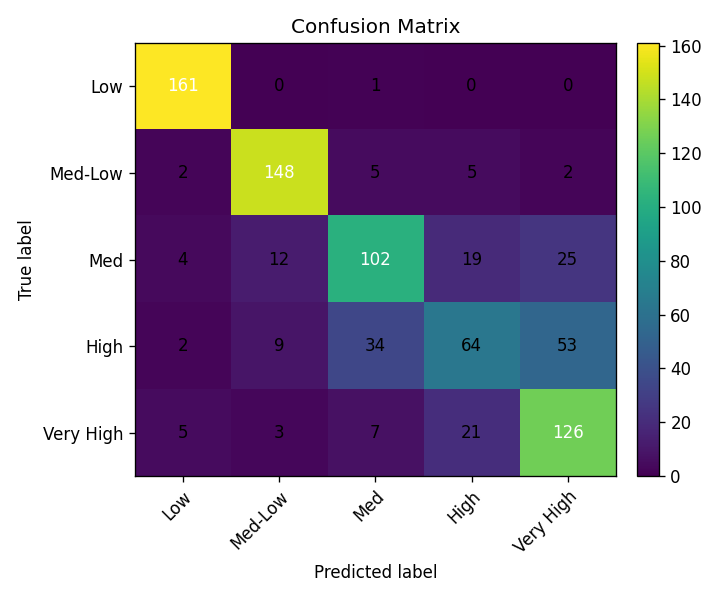

In [98]:

display(Image(filename='/kaggle/working/CM.png'))


**Explainability**

In [ ]:
#!pip install grad_cam

In [ ]:
import types
import cv2
plt.rcParams["figure.dpi"] = 120

# 1) helpers ------------------------------------------------------------
def preprocess_clip_image(img_path, img_size=224):
    mean=(0.48145466, 0.4578275, 0.40821073)
    std =(0.26862954, 0.26130258, 0.27577711)
    tfm = transforms.Compose([
        transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    pil = Image.open(img_path).convert("RGB")
    x = tfm(pil).unsqueeze(0)
    return pil, x

def overlay_heatmap(pil_img, cam, alpha=0.6):
    img = np.array(pil_img)
    heat = (cam * 255).astype(np.uint8)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)[:, :, ::-1]
    heat = cv2.resize(heat, (img.shape[1], img.shape[0]))
    return (alpha*heat + (1-alpha)*img).astype(np.uint8)

def patch_grid_for(img_size, patch=14):
    g = img_size // patch
    return (g, g)

# 2) Patch CLIP to expose/store attention weights 
def patch_residual_attention_block(block):
    orig_attention = block.attention  # method on the block

    def attention_with_weights(self, x: torch.Tensor):
        # Same as CLIP, but request weights and store them.
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        out, w = self.attn(x, x, x, need_weights=True, attn_mask=self.attn_mask)
        # Store attention probs on the attn module for hooks to read
        self.attn.last_attn = w  # [B, heads, N, N]
        return out

    block.attention = types.MethodType(attention_with_weights, block)

# 3) Rollout engine 
class ViTGradRollout:
    def __init__(self, clip_siamese, use_last_k=6, use_grads=False):
        self.model = clip_siamese.eval()
        self.blocks = list(self.model.clip_model.visual.transformer.resblocks)
        self.use_last_k = use_last_k
        self.use_grads = use_grads
        self.attns, self.attn_grads, self.hooks = [], [], []

        # Hooks read attn probs that stored in patch_residual_attention_block
        for blk in self.blocks:
            attn = blk.attn

            def fwd_hook(mod, inp, out):
                w = getattr(mod, "last_attn", None)  # [B, H, N, N]
                if w is not None:
                    self.attns.append(w.mean(dim=1))  # average heads → [B, N, N]

            self.hooks.append(attn.register_forward_hook(fwd_hook))

            if use_grads:
                pass

    def remove(self):
        for h in self.hooks:
            try: h.remove()
            except: pass

    @torch.no_grad()
    def _norm(self, x):
        x = x - x.min()
        return x / (x.max() + 1e-8)

    def __call__(self, x, score, patch_grid):
        A_list = self.attns[-self.use_last_k:]
        if len(A_list) == 0:
            raise RuntimeError("No attention maps captured.")

        Hp, Wp = patch_grid
        T = 1 + Hp*Wp
        device = A_list[0].device
        rollout = torch.eye(T, T, device=device)

        for A in A_list:
            A = A[0]  # B=1 -> [N,N]
            A = A / (A.sum(-1, keepdim=True) + 1e-8)           # row-normalize
            A = A + torch.eye(T, T, device=device)             # add residual
            A = A / (A.sum(-1, keepdim=True) + 1e-8)           # renormalize
            rollout = A @ rollout

        patch = rollout[0, 1:].reshape(Hp, Wp)                  # drop CLS token
        patch = self._norm(patch)

        cam = torch.tensor(patch[None, None].cpu().numpy()).float()
        cam = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)[0, 0].cpu().numpy()
        cam = self._norm(cam)
        return cam

# 4) Load your (Siamese) model that wraps CLIP
clip_model = model  
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.eval().to(device)

# Patch every CLIP block to store attn weights during forward
for blk in clip_model.clip_model.visual.transformer.resblocks:
    patch_residual_attention_block(blk)

# 5) Inputs / paths
left_path  = "/kaggle/input/test-set/test/bovidae/Caprinae/Bighorn sheep head/000001.jpg"
right_path = "/kaggle/input/test-set/test/caninae/Vulpini/blanford fox head/000005.jpg"

IMG_SIZE = 224                 # match your training size
HpWp = patch_grid_for(IMG_SIZE, patch=14)  # ViT-L/14 , patch=14

pilL, xL = preprocess_clip_image(left_path,  IMG_SIZE);  xL = xL.to(device)
pilR, xR = preprocess_clip_image(right_path, IMG_SIZE);  xR = xR.to(device)

# 6) Wrappers: explain LEFT given fixed RIGHT (and vice-versa)
class LeftOnlyWrapper(torch.nn.Module):
    def __init__(self, siamese_model, x_right_fixed):
        super().__init__()
        self.m  = siamese_model
        self.xr = x_right_fixed  

    def forward(self, x_left):
        out = self.m(x_left, self.xr)  
        vals, _ = out.max(dim=1) if out.ndim == 2 else (out.view(-1), None)
        return vals  # [B]

class RightOnlyWrapper(torch.nn.Module):
    def __init__(self, siamese_model, x_left_fixed):
        super().__init__()
        self.m  = siamese_model
        self.xl = x_left_fixed

    def forward(self, x_right):
        out = self.m(self.xl, x_right)
        print(out)
        vals, _ = out.max(dim=1) if out.ndim == 2 else (out.view(-1), None)
        return vals

wrapper_left  = LeftOnlyWrapper(clip_model, xR).to(device).eval()
wrapper_right = RightOnlyWrapper(clip_model, xL).to(device).eval()

# 7) Explain LEFT given RIGHT
engine = ViTGradRollout(clip_model, use_last_k=47, use_grads=False)

with torch.enable_grad():
    score_left = wrapper_left(xL)     # [1]
    score_left = score_left.squeeze() # scalar 

cam_left = engine(xL, score_left, patch_grid=HpWp)
print('LEFT cam stats:', cam_left.min(), cam_left.max(), cam_left.mean())
print('LEFT layers captured:', len(engine.attns))
engine.remove()

overlay_left = overlay_heatmap(pilL, cam_left, alpha=0.45)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plt.axis("off"); plt.title("Left Image"); plt.imshow(pilL)
plt.subplot(1,2,2); plt.axis("off"); plt.title("CAM explaining left (given right)"); plt.imshow(overlay_left)
plt.tight_layout()
plt.savefig("gradcam_overlay_left.png", dpi=300, bbox_inches="tight")
plt.close()

# 8) Explain RIGHT given LEFT
engine = ViTGradRollout(clip_model, use_last_k=47, use_grads=False)

with torch.enable_grad():
    score_right = wrapper_right(xR)   # [1]
    score_right = score_right.squeeze()

cam_right = engine(xR, score_right, patch_grid=HpWp)
print('RIGHT cam stats:', cam_right.min(), cam_right.max(), cam_right.mean())
print('RIGHT layers captured:', len(engine.attns))
engine.remove()

overlay_right = overlay_heatmap(pilR, cam_right, alpha=0.45)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plt.axis("off"); plt.title("Right Image"); plt.imshow(pilR)
plt.subplot(1,2,2); plt.axis("off"); plt.title("CAM explaining right (given left)"); plt.imshow(overlay_right)
plt.tight_layout()
plt.savefig("gradcam_overlay_right.png", dpi=300, bbox_inches="tight")
plt.close()